In [4]:
import os
import sys
AbsPath = os.path.abspath("")
sys.path.append(AbsPath+"/..")
#from Scripts.Plots import SDSS_Plots
from itertools import cycle
#Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1)
import matplotlib.pyplot as plt
from Functions import Functions as F
HMF_fun = F.Make_HMF_Interp()
from Functions.Functions import Make_HMF_Interp
import numpy as np
import matplotlib.pyplot as plt
import importlib
import colossus.halo.mass_adv as massdefs
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
cosmology.setCosmology("planck15")
from astropy.cosmology import Planck15 as Cosmo_AstroPy
Cosmo =cosmology.getCurrent()

h = Cosmo.h

#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}



#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

In [ ]:
importlib.reload(F)

In [2]:
F.DarkMatterToStellarMass?

Signature:      
F.DarkMatterToStellarMass(
    ['DM', 'z', 'Paramaters', 'ScatterOn=False', 'Scatter=0.001', 'Pairwise=True'],
)
Call signature:  F.DarkMatterToStellarMass(*args, **kwargs)
Type:            CPUDispatcher
String form:     CPUDispatcher(<function DarkMatterToStellarMass at 0x7fe83b3e7d08>)
File:            /data/pg1g15/STEEL/Functions/Functions.py
Docstring:      
This funtion returns Stellar mass in log10 Msun, all arguments should be passed in simmilar cosmology (Planck 15 unless otherwise stated)
DM and z is longer than 1 are assumed pairwise if N == M, otherwise Array N is calculated for all elements (M) of z. If N==M but pairwise is not desired pass Pairwise == False
Args:
    DM: Dark Matter in log10 Msun. Can be (1,), (N,), or (N, M)).
    z: Redshift. Can be (1,) or (M,) 
    Parameters: Python Dictonary Containing Subdictonary 'AbnMtch':
                    Containing Booleans: 'z_Evo', 'Moster', 'Override_0', 'Override_z', 'G18'
                    Containing P

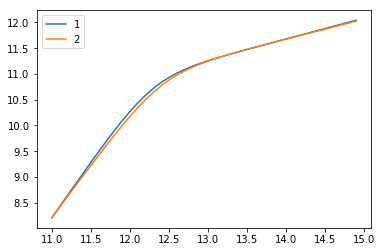

In [6]:
AbnMtch['G19_SE'] = True
Mh = np.arange(11, 15, 0.1)
for z in [1, 2]:
    Ms = F.DarkMatterToStellarMass(Mh, z, Paramaters)
    plt.plot(Mh, Ms, label = z)
plt.legend()
plt.show()
AbnMtch['G19_SE'] = False

In [ ]:
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}

AbnMtch['Override_0'] = False
AbnMtch['Override_z'] = False
AbnMtch['Override'] = Override

AbnMtch['G19_SE'] = True
for Redshift in Cosmo.lookbackTime([0, 4, 8, 12], inverse = True):
    plt.plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), Redshift, Paramaters, ScatterOn = False), label = round(Redshift,1))
plt.legend()
plt.show()    
AbnMtch['G19_SE'] = False

AbnMtch['Moster'] = True
for Redshift in Cosmo.lookbackTime([0, 4, 8, 12], inverse = True):
    plt.plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), Redshift, Paramaters, ScatterOn = False), label = round(Redshift,1))
plt.legend()
plt.show()
AbnMtch['Moster'] = False

In [ ]:
Cosmo.lookbackTime?

In [ ]:
Override =\
{\
'M10':11.8,\
'SHMnorm10':0.018,\
'beta10':1.5,\
'gamma10':0.31,\
'M11':0,\
'SHMnorm11':-0.01,\
'beta11':0.0,\
'gamma11':-0.12\
}

SM_bin = 0.1
SMF_Bins = np.arange(9, 12.5, SM_bin)
Halo_bin = 0.1
Halo_MR = np.arange(10, 16, Halo_bin)
Halo_MR_m200 = np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, Halo_MR), z=0.1, mdef_in='vir', mdef_out='200c')[0])



AbnMtch['Illustris'] =  False


AbnMtch['Override_0'] = True
AbnMtch['Override_z'] = True
AbnMtch['Override'] = Override

for Snap in (99, 67, 50, 40, 33, 25):
    Redshift = (100/Snap) -1
    f, axarr = plt.subplots(1, 3, figsize=(10,4))
    
    
    axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), Redshift, Paramaters, ScatterOn = False), "-C0", label = "Fit")
    SMHM_ill = np.load('./PaperTwoPlotData/Illustris/SMHM_fillbtwn_{}.npy'.format(Snap))
    axarr[0].fill_between(SMHM_ill[0]- np.log10(h), SMHM_ill[1]- np.log10(h), SMHM_ill[2]- np.log10(h), color = 'k', alpha = 0.5, label = 'Illustris')
    axarr[0].set_xlim(11, 14.5)
    axarr[0].set_ylim(8.5, 12.5)
    axarr[0].set_xlabel(r"log10 Halo Mass $M_{\odot}$")
    axarr[0].set_ylabel(r"log10 Stellar Mass $M_{\odot}$")
    
    SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR_m200- np.log10(h), Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
    axarr[1].plot(SMF_Bins, SMF, "-C0")
    SMF_ill = np.load('./PaperTwoPlotData/Illustris/SMF_errbar_{}.npy'.format(Snap))
    axarr[1].errorbar(SMF_ill[0]- np.log10(h), SMF_ill[1], yerr = [SMF_ill[2], SMF_ill[3]], color = 'k',  fmt = "s", label = 'Illustris', mfc = None, fillstyle = "none")
    axarr[1].set_ylim(-5, -2)
    axarr[1].set_title(round(Redshift, 2))
    axarr[1].set_xlabel(r"log10 Stellar Mass $M_{\odot}$")
    axarr[1].set_ylabel(r"$log_{10}  \phi$ $[Mpc^{-3} dex^{-1}]$")
    
    HMF_ill = np.load('./PaperTwoPlotData/Illustris/HMF_errbar_{}.npy'.format(Snap))
    axarr[2].errorbar(HMF_ill[0]- np.log10(h), HMF_ill[1], yerr = [HMF_ill[2], HMF_ill[3]], color = 'k',  fmt = "s", label = 'Illustris', mfc = None, fillstyle = "none")
    axarr[2].set_ylim(-5, -2)
    axarr[2].set_xlim(11, 15)
    axarr[2].plot(Halo_MR_m200 - np.log10(h), np.log10(HMF_fun(Halo_MR, Redshift)) +3*np.log10(h), "-C0")
    axarr[2].set_xlabel(r"log10 Halo Mass $M_{\odot}$")
    axarr[2].set_ylabel(r"$log_{10}  \phi$ $[Mpc^{-3} dex^{-1}]$")
    
    plt.tight_layout()
    
    plt.savefig("./PaperTwoPlotData/Illustris/Plots/HMSM_SMF_HMF{}.png".format(round(Redshift, 2)))
    
    plt.show()
    plt.clf()
    
AbnMtch['Override_0'] = False
AbnMtch['Override_z'] = False
AbnMtch['Illustris'] =  False

In [ ]:
for HM_c in [12.5,14]:
    HM_s = np.arange(10, 12.5, 0.1)

    #halo mass ratio converted to natural numbers
    Mh_Ms = np.power(10, HM_c - HM_s)
    #Catteneo++ 2011
    Strip = np.power(0.6, (1.428/(2*np.pi))*(Mh_Ms/np.log(1+Mh_Ms)))


    #plt.plot(HM_s, (1.428/(2*np.pi))*(Mh_Ms/np.log(1+Mh_Ms)))
    #plt.show()

    #plt.plot(HM_s, Strip)
    #plt.show()

    plt.plot(np.log10(Mh_Ms), np.log10(Strip))
plt.ylim(-1, 0)
plt.xlim(0.0, 2.0)
plt.show()

In [ ]:
RunParam = ('1.0', True, True, True, 'Illustris', 'Illustris')
"./Other_Data_Outputs/Total_StarFormation_Means_{}".format("".join(("{}_".format(i) for i in RunParam)))

In [ ]:
AvaHaloMass, Surviving_Sat_SMF_MassRange, Total_StarFormation_Means, Total_StarFormation_Std = F.LoadData_Total_Starformation(('1.0', True, False, True, 'CE', 'G19_SE'))
f
print(np.shape(Total_StarFormation_Means))

In [ ]:
print(Total_StarFormation_Means[10][50])
print(Total_StarFormation_Std[10][50])

In [ ]:
from matplotlib.gridspec import GridSpec

In [ ]:
from matplotlib import cm
ColourMap = cm.viridis

fig = plt.figure(figsize=[12, 4])
gs = GridSpec(4, 13, hspace=0.0,wspace=0.0,figure=fig)
ax1 = fig.add_subplot(gs[0:4, 0:4])
ax2 = fig.add_subplot(gs[0:4, 4:8])
ax3 = fig.add_subplot(gs[0:4, 8:12])
ColorBar = fig.add_subplot(gs[0:4, 12:13])

AvaHaloMass_s, z_s, Surviving_Sat_SMF_MassRange_s, Total_StarFormation_Means_s, Total_StarFormation_Std_s = F.LoadData_Total_Starformation(('1.0', True, False, True, 'CE', 'G19_SE'))
AvaHaloMass_s_sf, z_s_sf, Surviving_Sat_SMF_MassRange_s_sf, Total_StarFormation_Means_s_sf, Total_StarFormation_Std_s_sf = F.LoadData_Total_Starformation(('1.0', True, True, True, 'CE', 'G19_SE'))
AvaHaloMass_sf, z_sf, Surviving_Sat_SMF_MassRange_sf, Total_StarFormation_Means_sf, Total_StarFormation_Std_sf = F.LoadData_Total_Starformation(('1.0', False, True, True, 'CE', 'G19_SE'))


def GetColour(HM):
    Min = np.min(AvaHaloMass_s)
    Max = np.max(AvaHaloMass_s)
    return ColourMap(float((HM-Min)/(Max-Min)))


for i in np.arange(np.min(AvaHaloMass_s), np.max(AvaHaloMass_s), 0.01):
    ColorBar.fill_between([-0.5, 1.5], i, i+0.01, color = GetColour(i))
ColorBar.set_ylim(np.min(AvaHaloMass_s), np.max(AvaHaloMass_s))
ColorBar.set_xlim(0, 1)
ColorBar.yaxis.tick_right()
ColorBar.yaxis.set_label_position("right")
ColorBar.set_ylabel("HaloMass")

for i in range(0, 56):
    for z_bin in range(0, 189):
        colour = GetColour(AvaHaloMass[z_bin, i])
        ax1.plot(Surviving_Sat_SMF_MassRange_s, Total_StarFormation_Means_s[z_bin][i]/np.power(10, Surviving_Sat_SMF_MassRange_s), "x", color = colour, alpha = 0.5)
        ax2.plot(Surviving_Sat_SMF_MassRange_s_sf, Total_StarFormation_Means_s_sf[z_bin][i]/np.power(10, Surviving_Sat_SMF_MassRange_s_sf), "x", color = colour, alpha = 0.5)
        ax3.plot(Surviving_Sat_SMF_MassRange_sf, Total_StarFormation_Means_sf[z_bin][i]/np.power(10, Surviving_Sat_SMF_MassRange_sf), "x", color = colour, alpha = 0.5)
ax1.set_title("Stripping")
ax1.set_ylabel(r"$log10[M_{evo}/M_{frozen}]$")
#ax1.set_xlabel(r"Mfrozen $M_{\odot}$")   
ax2.set_title("Stripping and Starformation")
#ax2.set_ylabel(r"$log10[M_{evo}/M_{frozen}]$")
ax2.set_xlabel(r"Mfrozen $M_{\odot}$") 
ax3.set_title("Starformation")
#ax3.set_ylabel(r"$log10[M_{evo}/M_{frozen}]$")
#ax3.set_xlabel(r"Mfrozen $M_{\odot}$") 


plt.savefig("./PaperTwoPlotData/StellarMassEvolution.png")
plt.show()

In [ ]:
colours = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "k"] 

z_bin = 0

colourcycler = cycle(colours)
AvaHaloMass, Surviving_Sat_SMF_MassRange, Total_StarFormation_Means, Total_StarFormation_Std = F.LoadData_Total_Starformation(('1.0', True, False, True, 'CE', 'G19_SE'))
for i in [10, 20, 30, 40, 50]:
    colour = next(colourcycler)
    plt.plot(Surviving_Sat_SMF_MassRange, Total_StarFormation_Means[z_bin][i]/np.power(10, Surviving_Sat_SMF_MassRange), "--", label = round(AvaHaloMass[z_bin, i], 2), color = colour)
plt.title("Stripping")
plt.ylabel(r"$log10[M_{evo}/M_{frozen}]$")
plt.xlabel(r"Mfrozen $M_{\odot}$")   
plt.legend()
plt.show()
    
colourcycler = cycle(colours)
AvaHaloMass, Surviving_Sat_SMF_MassRange, Total_StarFormation_Means, Total_StarFormation_Std = F.LoadData_Total_Starformation(('1.0', True, True, True, 'CE', 'G19_SE'))
for i in [10, 20, 30, 40, 50]:
    colour = next(colourcycler)
    plt.plot(Surviving_Sat_SMF_MassRange, Total_StarFormation_Means[i]/np.power(10, Surviving_Sat_SMF_MassRange), "-.", label = round(AvaHaloMass[0, i], 2), color = colour)
plt.title("Stripping and Starformation")
plt.ylabel(r"$log10[M_{evo}/M_{frozen}]$")    
plt.xlabel(r"Mfrozen $M_{\odot}$")    
plt.legend()
plt.show()


colourcycler = cycle(colours)
AvaHaloMass, Surviving_Sat_SMF_MassRange, Total_StarFormation_Means, Total_StarFormation_Std = F.LoadData_Total_Starformation(('1.0', False, True, True, 'CE', 'G19_SE'))
for i in [10, 20, 30, 40, 50]:
    colour = next(colourcycler)
    plt.plot(Surviving_Sat_SMF_MassRange, Total_StarFormation_Means[i]/np.power(10, Surviving_Sat_SMF_MassRange), "-.", label = round(AvaHaloMass[0, i], 2), color = colour)
plt.title("Starformation")
plt.ylabel(r"$log10[M_{evo}/M_{frozen}]$")    
plt.xlabel(r"Mfrozen $M_{\odot}$")    
plt.legend()
plt.show()


In [ ]:
StripFactor  = 10**F.StellarMassLoss(14.0, 13.0, 10.0, np.arange(4, 0, -0.1), 2.0, factor_only = True)
print(StripFactor)

In [ ]:
Start = 1
Out = []
StipFac_delta = StripFactor[:-1] - StripFactor[1:]
for i in StripFactor:
    Out.append(((2*i)-1))
print(Out)

In [ ]:
StipFac_delta[:,-1]

In [ ]:
round(12.43745, 2)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
A = np.array([1,2,3])
B = np.array([4,5,6])
C = np.vstack((A,B))

In [9]:
np.repeat?

Signature: np.repeat(a, repeats, axis=None)
Docstring:
Repeat elements of an array.

Parameters
----------
a : array_like
    Input array.
repeats : int or array of ints
    The number of repetitions for each element.  `repeats` is broadcasted
    to fit the shape of the given axis.
axis : int, optional
    The axis along which to repeat values.  By default, use the
    flattened input array, and return a flat output array.

Returns
-------
repeated_array : ndarray
    Output array which has the same shape as `a`, except along
    the given axis.

See Also
--------
tile : Tile an array.

Examples
--------
>>> np.repeat(3, 4)
array([3, 3, 3, 3])
>>> x = np.array([[1,2],[3,4]])
>>> np.repeat(x, 2)
array([1, 1, 2, 2, 3, 3, 4, 4])
>>> np.repeat(x, 3, axis=1)
array([[1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4]])
>>> np.repeat(x, [1, 2], axis=0)
array([[1, 2],
       [3, 4],
       [3, 4]])
File:      ~/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py
Type:      function


In [7]:
np.histogram?

Signature:
np.histogram(
    ['a', 'bins=10', 'range=None', 'normed=None', 'weights=None', 'density=None'],
)
Docstring:
Compute the histogram of a set of data.

Parameters
----------
a : array_like
    Input data. The histogram is computed over the flattened array.
bins : int or sequence of scalars or str, optional
    If `bins` is an int, it defines the number of equal-width
    bins in the given range (10, by default). If `bins` is a
    sequence, it defines the bin edges, including the rightmost
    edge, allowing for non-uniform bin widths.

    .. versionadded:: 1.11.0

    If `bins` is a string, it defines the method used to calculate the
    optimal bin width, as defined by `histogram_bin_edges`.

range : (float, float), optional
    The lower and upper range of the bins.  If not provided, range
    is simply ``(a.min(), a.max())``.  Values outside the range are
    ignored. The first element of the range must be less than or
    equal to the second. `range` affects the automat

In [ ]:
np.save?

In [ ]:
def SFR_t_fit(M_out, z = 0.5):
    s0 = 0.6+ 1.22*(z) - 0.2*(z**2)
    logM0 = 10.3 + 0.753*(z) - 0.15*(z**2)
    
    
    Gamma = -(1.3 - 0.1*(z))# + 0.05*(z**2))#including -ve here to avoid it later
    
    
    log10MperY = s0 - np.log10(1 + np.power(np.power(10, (M_out - logM0) ), Gamma))
    return log10MperY

In [ ]:
def SFR_s(SM, z):
    """
    Calculates Starformation rate
    Args:
    SM: Stellar Mass [log10 Msun]
    z: Redshift
    Returns:
    SFR: Star formation rate [log10 Msun yr-1]
    """
    m = SM-9; r = np.log10(1+z)
    m0, a0, a1, m1, a2 = 0.5, 1.5, 0.3, 0.36, 2.5
    Max = m-m1-a2*r
    Max[Max<0] = 0
    log10MperY = m-m0+a0*r-a1*np.power(Max, 2)
    return log10MperY

In [ ]:
def SFR_t_refit(M_out, z = 0.5):
    s0 = 0.85+ 1.2*(z) - 0.18*(z**2)
    logM0 = 10.5 + 0.753*(z) - 0.15*(z**2)
    
    
    Gamma = -(1.1)# - 0.1*(z))# + 0.05*(z**2))#including -ve here to avoid it later
    
    
    log10MperY = s0 - np.log10(1 + np.power(np.power(10, (M_out - logM0) ), Gamma))
    return log10MperY

In [ ]:
def SFR_testfit(M_out, z = 0.5):
    M_break = 10.6+ 0.2*z - 0.06*(z**2)
    M_b_idx = np.digitize(M_break, bins = M_out)
    LM_slope = 1.05
    LM_int = -10.15 + 0.375*z - 0.02*(z**2)
    HM_slope = -1.1 + 0.4*z
    HM_int = (LM_slope*M_break + LM_int) - HM_slope*M_break 
    log10MperY = LM_slope*M_out + LM_int
    log10MperY[M_b_idx:] = HM_slope*M_out[M_b_idx:]+ HM_int
    return log10MperY
    

In [ ]:
np.ma.masked_inside(Data[2], 0.9, 1)

In [ ]:
import os

In [ ]:
os.listdir(path="../../")

In [ ]:
import os
AbsPath = os.path.abspath("")

In [ ]:
AbsPath

In [ ]:
os.listdir(path=AbsPath+"/..")

In [ ]:
from distutils.core import setup
from Cython.Distutils import Extension
from Cython.Distutils import build_ext

In [ ]:
build_ext?